#### Importación de las librerías y del DF

In [325]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdates
import statistics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

In [204]:
df = pd.read_csv("train.csv")

#### Limpieza de datos y análisis de los mismos

In [205]:
df.replace(df["final_status"].unique()[0], 1,inplace=True)
df.replace(df["final_status"].unique()[1], 0, inplace=True)

In [206]:
df["local_time"] = pd.to_datetime(df["local_time"],format= '%H:%M:%S') #.dt.time
#Voy a transformar los datos a una fecha completa porque es más sencillo graficarla que si solo aparece la hora.

In [207]:
df.groupby(["final_status","payment_status"]).size()
#La columna "payment_status" no parece tan relacionada, aunque podemos dumificarla y ver si el score aumenta

final_status  payment_status
0             DELAYED               1
              NOT_PAID            118
              PAID               5713
1             DELAYED               5
              NOT_PAID            352
              PAID              48141
dtype: int64

In [208]:
df.groupby(["country_code","final_status"]).size()
#La columna "payment_status" tampoco parece tan relacionada, aunque también se puede dumificar

country_code  final_status
AR            0                1747
              1               10107
BR            0                   1
CI            0                   3
              1                   3
CL            0                 137
              1                 857
CR            0                  74
              1                 926
DO            0                  39
              1                 409
EC            0                 234
              1                2031
EG            0                 196
              1                1447
ES            0                 920
              1               10634
FR            0                 157
              1                1754
GE            0                  70
              1                 415
GT            0                  43
              1                 468
IT            0                 261
              1                2276
KE            0                   7
              1                  77
M

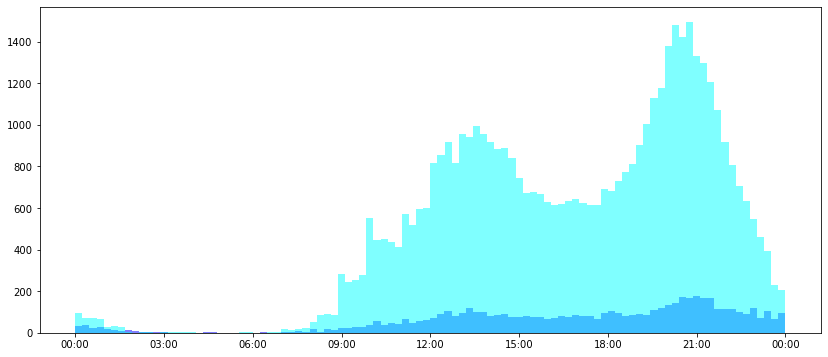

In [209]:
fig,ax = plt.subplots(figsize=(14,6))
plt.hist(df[(df["final_status"]==0)]["local_time"], bins=100, alpha=0.5, color="blue")
plt.hist(df[(df["final_status"]==1)]["local_time"], bins=100, alpha=0.5, color="cyan")
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.show()
#Parece que aunque siempre hay más pedidos entregados que cancelados, esa proporción disminuye por la noche

## Ahora resolveremos algunas cuestiones para ayudar a resolver el problema final

### ¿Cuáles son los 3 paises en los que más pedidos se realizan?

In [210]:
df.groupby(["country_code"]).size().sort_values(ascending=False)[:3] #Son Argentina, España y Turquía

country_code
AR    11854
ES    11554
TR     5696
dtype: int64

### ¿Cuáles son las horas en las que se realizan más pedidos en España?

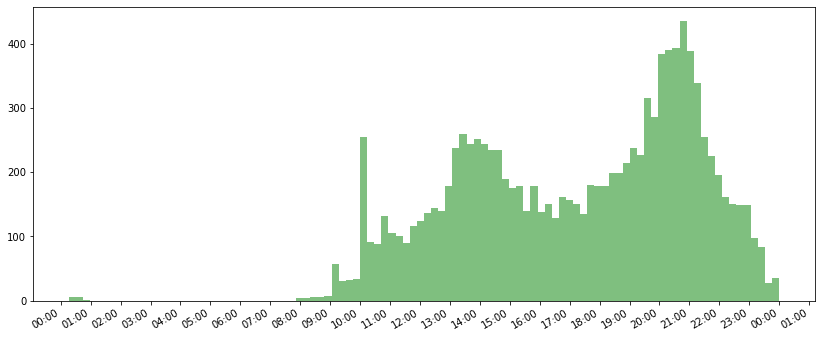

In [211]:
fig,ax = plt.subplots(figsize=(14,6))
plt.hist(df[(df["country_code"]=="ES")]["local_time"], bins=100, alpha=0.5, color="green")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
plt.show()
#Se ve que el pico más alto está entre las 7:30 y las 9:30

### ¿Cuál es el precio medio por pedido en la tienda con ID 12513?

In [212]:
df[(df["store_address"]==12513)]["products_total"].mean() #17.39

17.392244897959173

Teniendo en cuenta los picos de demanda en España, si los repartidores trabajan en turnos de 8horas.
<li> Turno 1 (00:00-08:00)
<li> Turno 2 (08:00-16:00)
<li> Turno 3 (16:00-00:00)

### ¿Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda? (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%).

In [213]:
turno1=df[(df["country_code"]=="ES")&(df["local_time"]<pd.to_datetime("8:00",format= '%H:%M'))]["order_id"].count()

In [214]:
turno2=df[(df["country_code"]=="ES")&(df["local_time"]>=pd.to_datetime("8:00",format= '%H:%M'))
   &(df["local_time"]<pd.to_datetime("16:00",format= '%H:%M'))]["order_id"].count()

In [215]:
turno3=df[(df["country_code"]=="ES")&(df["local_time"]>=pd.to_datetime("16:00",format= '%H:%M'))]["order_id"].count()

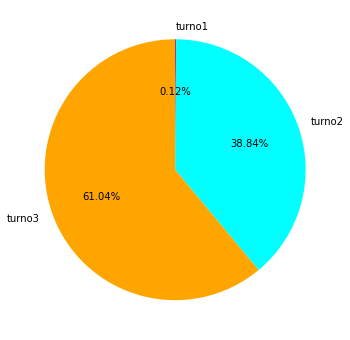

In [216]:
fig, ax = plt.subplots(figsize=(8,6))
plt.pie([turno1,turno2,turno3],startangle=90,labels=["turno1","turno2","turno3"],
        counterclock=False,colors=["purple","cyan","orange"],autopct = '%1.2f%%',radius=1)
plt.show() #Estos serían los porcentajes ideales para hacer frente a los turnos de reparto.

### Modelo predictivo de machine learning a partir del dataset 'train.csv' en el cual a partir de las variables predictoras que se entregan en el dataset 'test_X' se pueda predecir si el pedido se cancelará o no (columna 'final_status').

#### Intentamos un modelo rápido con un RandomForest, en el que quitamos las columnas categóricas

In [371]:
X = df.drop(["order_id","final_status","local_time","country_code","payment_status","store_address"],axis=1)

In [372]:
X["local_time"] = df["local_time"].dt.strftime("%H:%M:%S")

In [373]:
X["local_time"] = pd.to_timedelta(X["local_time"]).dt.total_seconds() # Transformamos el tiempo en un timedelta

In [374]:
y = df[["final_status"]]

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
yhat = rf.predict(X_test)
print(recall_score(y_test,yhat)) #El recall parece muy alto pero...


<ipython-input-262-77a86001db77>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)


0.9798685291700904


In [263]:
print(confusion_matrix(y_test,yhat)) #De la clase minoritaria, que es la que más nos interesan, se aciertan muy pocos.
#Así que vamos a intentar mejorar los números de la fila de arriba.

[[   70  1625]
 [  294 14310]]


In [375]:
for columna in ["country_code","payment_status","store_address"]:
    dummy_variable = pd.get_dummies(df[columna], prefix=str(columna), prefix_sep="_")
    X= pd.concat([X, dummy_variable], sort=False, axis=1)


In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
yhat = rf.predict(X_test)
print(recall_score(y_test,yhat))

<ipython-input-288-77a86001db77>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)


0.9707518022657055


In [289]:
print(confusion_matrix(y_test,yhat))

[[  220  1514]
 [  426 14139]]


#### Con esto mejora un poco pero sigue fallando demasiado en predecir los pedidos cancelados. Probemos otros modelos.

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
yhat = gnb.predict(X_test)
print(recall_score(y_test,yhat))
print(confusion_matrix(y_test,yhat))

C:\Users\JC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9871628542164561
[[   48  1606]
 [  188 14457]]


In [322]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
knn = KNeighborsClassifier(1, algorithm="brute")
knn = knn.fit(X_train, y_train)
yhat = knn.predict(X_test)
print(recall_score(y_test,yhat))
print(confusion_matrix(y_test,yhat))

C:\Users\JC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.9002476609796367
[[  199  1564]
 [ 1450 13086]]


In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lr = LogisticRegression(max_iter=150)
lr = lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
print(recall_score(y_test,yhat))
print(confusion_matrix(y_test,yhat))

C:\Users\JC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


1.0
[[    0  1733]
 [    0 14566]]


#### Con esto decidimos que los mejores modelos son el RandomForest y el KNN pero aun así, para mejorar el número de pedidos cancelados probaremos haciendo un undersampling.

In [361]:
undersampling = RandomUnderSampler(sampling_strategy=0.5)
#Especificamos que la clase minoritaria represente el 50% de la clase mayoritaria

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf = RandomForestClassifier()
X_balanceado, y_balanceado = undersampling.fit_resample(X_train, y_train)
rf = rf.fit(X_balanceado, y_balanceado)
yhat = rf.predict(X_test)
print(recall_score(y_test,yhat))

<ipython-input-362-d289fdbe7a4e>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_balanceado, y_balanceado)


0.8709766351919498


In [363]:
print(confusion_matrix(y_test,yhat)) #Con el smote el resultado de los pedidos cancelados se mejoran bastante

[[  613  1177]
 [ 1872 12637]]


In [364]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
knn = KNeighborsClassifier(1, algorithm="brute")
X_balanceado, y_balanceado = undersampling.fit_resample(X_train, y_train)
knn = knn.fit(X_balanceado, y_balanceado)
yhat = knn.predict(X_test)
print(recall_score(y_test,yhat))
print(confusion_matrix(y_test,yhat))

C:\Users\JC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.6757442721909727
[[ 604 1117]
 [4727 9851]]


#### Como se ve, los datos para los pedidos cancelados se predicen mucho mejor así, pero en general las cifras son peor así porque en la otra clase se equivoca mucho mejor.

In [365]:
kf = KFold(n_splits=5)
yhatlist = []
f1 = []
for train_index, test_index in kf.split(np.array(X), np.array(y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_balanceado, y_balanceado = undersampling.fit_resample(X_train, y_train)
    rf = RandomForestClassifier()
    rf = rf.fit(X_balanceado, y_balanceado)
    yhat = rf.predict(X_test)
    yhatlist.extend(yhat)
    f1.append(f1_score(y_test,yhat))
conf_mat = confusion_matrix(y, yhatlist)
print(statistics.mean(f1))
print(conf_mat)

0.8950309542902202
[[ 1957  3875]
 [ 6075 42423]]


In [366]:
kf = KFold(n_splits=5)
yhatlist = []
f1 = []
for train_index, test_index in kf.split(np.array(X), np.array(y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_balanceado, y_balanceado = undersampling.fit_resample(X_train, y_train)
    knn = KNeighborsClassifier(1, algorithm="brute")
    knn = knn.fit(X_balanceado, y_balanceado)
    yhat = knn.predict(X_test)
    yhatlist.extend(yhat)
    f1.append(f1_score(y_test,yhat))
conf_mat = confusion_matrix(y, yhatlist)
print(statistics.mean(f1))
print(conf_mat)

0.7760971923834254
[[ 2057  3775]
 [15350 33148]]


In [367]:
kf = KFold(n_splits=5)
yhatlist = []
f1 = []
for train_index, test_index in kf.split(np.array(X), np.array(y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestClassifier()
    rf = rf.fit(X_train, y_train)
    yhat = rf.predict(X_test)
    yhatlist.extend(yhat)
    f1.append(f1_score(y_test,yhat))
conf_mat = confusion_matrix(y, yhatlist)
print(statistics.mean(f1))
print(conf_mat)

<ipython-input-367-1ab27a5c941c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)
<ipython-input-367-1ab27a5c941c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)
<ipython-input-367-1ab27a5c941c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)
<ipython-input-367-1ab27a5c941c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)
<ipython-input-367-1ab27a5c941c>:10: DataConversionWarning: A column-vector y was passed when a 1d array

0.9379060922247325
[[  865  4967]
 [ 1284 47214]]


In [368]:
kf = KFold(n_splits=5)
yhatlist = []
f1 = []
for train_index, test_index in kf.split(np.array(X), np.array(y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn = KNeighborsClassifier(1, algorithm="brute")
    knn = knn.fit(X_train, y_train)
    yhat = knn.predict(X_test)
    yhatlist.extend(yhat)
    f1.append(f1_score(y_test,yhat))
conf_mat = confusion_matrix(y, yhatlist)
print(statistics.mean(f1))
print(conf_mat)

C:\Users\JC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\JC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\JC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\JC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

0.8966240017120869
[[  727  5105]
 [ 4939 43559]]


### En conclusión: cuantos más pedidos cancelados acierta, menos f1_score tiene. Habría que ver qué preferimos, si un modelo que acierte más pedidos cancelados o uno que acierte más en general. El orden empezando por cuál tiene más f1 sería el siguiente:

<li> RandomForest sin Undersampling
<li> KNN sin Undersampling
<li> RandomForest con Undersampling
<li> KNN con Undersampling

### Y el ganador es: RandomForest con Undersampling.

#### Elegimos este modelo ya que, aunque tenga el segundo peor f1-score, también es el segundo más sensible y creemos que para esta predicción es lo más importante. El KNN con Undersampling lo descartamos ya que lo que acierta con respecto al RandomForest no compensa con lo que falla.

In [377]:
df_test = pd.read_csv("test_X.csv",delimiter=";")

In [378]:
X_test = df_test.drop(["order_id","local_time","country_code","payment_status","store_address"],axis=1)

In [379]:
X_test["local_time"] = pd.to_timedelta(df_test["local_time"]).dt.total_seconds()

In [380]:
for columna in ["country_code","payment_status","store_address"]:
    dummy_variable = pd.get_dummies(df_test[columna], prefix=str(columna), prefix_sep="_")
    X_test= pd.concat([X_test, dummy_variable], sort=False, axis=1)

In [381]:
set_X_test=set(X_test.columns)

In [382]:
set_X = set(X.columns)

In [383]:
columnasnuevas = set_X.difference(set_X_test)

In [388]:
for i in columnasnuevas:
    X_test[i] = 0

In [390]:
X_balanceado, y_balanceado = undersampling.fit_resample(X, y)

In [391]:
knn = KNeighborsClassifier(1, algorithm="brute")
knn = knn.fit(X_balanceado, y_balanceado)
yhat = knn.predict(X_test)

C:\Users\JC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [393]:
prediccion = pd.DataFrame()

In [394]:
prediccion["Predicción Final"] = yhat

In [396]:
prediccion.to_csv("prediccion.csv")